In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
folderpath = 'D:\Programming\AI\datasets\cat-faces-64x64rgb-8k\images'
counter = 0
img = None
for fname in os.listdir(folderpath):
    if img is None:
        fpath = os.path.join(folderpath, fname)
        img = img_to_array(load_img(fpath))
    counter += 1
images = np.zeros((counter,*img.shape))
counter = 0
for fname in os.listdir(folderpath):
    fpath = os.path.join(folderpath, fname)
    images[counter] = img_to_array(load_img(fpath))
    counter += 1
    if counter % 500 == 0:
        print(f"Finished reading {counter} images")
print(f"Final shape of images is {images.shape}")

Finished reading 500 images
Finished reading 1000 images
Finished reading 1500 images
Finished reading 2000 images
Finished reading 2500 images
Finished reading 3000 images
Finished reading 3500 images
Finished reading 4000 images
Finished reading 4500 images
Finished reading 5000 images
Finished reading 5500 images
Finished reading 6000 images
Finished reading 6500 images
Finished reading 7000 images
Finished reading 7500 images
Finished reading 8000 images
Finished reading 8500 images
Finished reading 9000 images
Finished reading 9500 images
Finished reading 10000 images
Finished reading 10500 images
Finished reading 11000 images
Finished reading 11500 images
Finished reading 12000 images
Finished reading 12500 images
Finished reading 13000 images
Finished reading 13500 images
Finished reading 14000 images
Finished reading 14500 images
Finished reading 15000 images
Finished reading 15500 images
Final shape of images is (15747, 64, 64, 3)


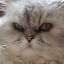

In [3]:
array_to_img(images[0])

In [4]:
images = (images.astype('float32') - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 128
noise_dim = 100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [11]:
def make_generator_model():
    inputs = layers.Input(shape=(noise_dim,))
    d = layers.Dense(16 * 16 * 64, activation="relu",use_bias=False)(inputs)
    r = layers.Reshape((16, 16, 64))(d)
    c1t = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(r)
    c2t = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(c1t)
    outputs = layers.Conv2DTranspose(3, 3, activation="tanh", padding="same")(c2t)
    return tf.keras.models.Model(inputs,outputs)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 3)         435       
Total params: 1,661,923
Trainable params: 1,661,923
Non-trainable params: 0
_________________________________________________

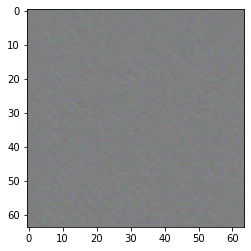

In [12]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :] + 0.5)

In [13]:
def make_discriminator_model():
    inputs = layers.Input(shape=(64,64,3))
    c1 = layers.Conv2D(32,(5,5),strides=(2,2),padding="same",activation="relu")(inputs)
    dr1 = layers.Dropout(0.15)(c1)
    c2 = layers.Conv2D(64,(5,5),strides=(2,2),padding="same",activation="relu")(dr1)
    dr2 = layers.Dropout(0.15)(c2)
    c3 = layers.Conv2D(128,(5,5),strides=(2,2),padding="same",activation="relu")(dr2)
    dr3 = layers.Dropout(0.15)(c3)
    f = layers.Flatten()(dr3)
    dd1 = layers.Dense(100,activation="relu")(f)
    outputs = layers.Dense(1)(dd1)
    return tf.keras.models.Model(inputs,outputs)

In [14]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 128)         0   

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [18]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()


In [19]:
checkpoint_dir = './training_checkpoints/catgan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [29]:

current_epoch = 200

In [26]:
import math
def train(dataset, epochs):
    global current_epoch
    n_batches = math.ceil(BUFFER_SIZE / BATCH_SIZE)
    for epoch in range(epochs):
        current_epoch += 1
        start = time.time()
        gen_loss = np.zeros(n_batches)
        disc_loss = np.zeros(n_batches)
        n = 0
        for image_batch in dataset:
            gen_loss[n],disc_loss[n] = train_step(image_batch)
            n += 1
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 current_epoch,
                                 seed)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(current_epoch + 1, time.time()-start))
        print(f"avg gen loss: {np.mean(gen_loss)}")
        print(f"avg disc loss: {np.mean(disc_loss)}")

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,current_epoch,seed)

In [27]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    if epoch % 10 == 0:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


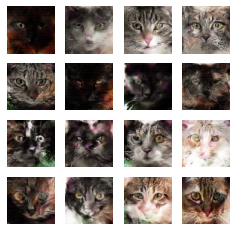

Time for epoch 600 is 10.53649091720581 sec
avg gen loss: 6.043194286284908
avg disc loss: 0.10111642349511385


ValueError: setting an array element with a sequence.

In [31]:
EPOCHS = 300
train(train_dataset, EPOCHS)


In [19]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [33]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

In [36]:
generator.save('keras-catganh5.h5')

In [34]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(generator, 'catganh5.h5')

ModuleNotFoundError: No module named 'tensorflowjs'